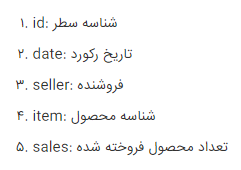

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/sales/train.csv')
df.head()

,id,date,seller,item,sales
0,0,2015-05-01,1,1,21
1,1,2015-05-01,2,1,45
2,2,2015-05-01,3,1,28
3,3,2015-05-01,4,1,34
4,4,2015-05-01,5,1,21


In [3]:
df['date'] = pd.to_datetime(df['date'])
df.head()

,id,date,seller,item,sales
0,0,2015-05-01,1,1,21
1,1,2015-05-01,2,1,45
2,2,2015-05-01,3,1,28
3,3,2015-05-01,4,1,34
4,4,2015-05-01,5,1,21


In [4]:
df[['seller' , 'item']].values

array([[ 1,  1],
       [ 2,  1],
       [ 3,  1],
       ...,
       [ 8, 50],
       [ 9, 50],
       [10, 50]], dtype=int64)

In [5]:
min(df['date']) , max(df['date'])

(Timestamp('2015-05-01 00:00:00'), Timestamp('2020-04-03 00:00:00'))

In [4]:
def to_integer(dt_time):
    return 365*dt_time.year + 100*dt_time.month + dt_time.day

In [5]:
df['datechanged'] = df['date'].apply(lambda x : to_integer(x))

In [6]:
df.head()

,id,date,seller,item,sales,datechanged
0,0,2015-05-01,1,1,21,20150501
1,1,2015-05-01,2,1,45,20150501
2,2,2015-05-01,3,1,28,20150501
3,3,2015-05-01,4,1,34,20150501
4,4,2015-05-01,5,1,21,20150501


In [89]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
X=enc.fit_transform(df[['seller' , 'item' ]].values)

In [90]:
X.shape

(900000, 60)

In [42]:
from sklearn.decomposition import TruncatedSVD
ncomp=16
svd = TruncatedSVD(n_components=ncomp, random_state=42)
dimX = svd.fit_transform(X)

In [37]:
df[['datechanged']].values.shape

(900000, 1)

In [43]:
dimX.shape

(900000, 16)

In [44]:
dimX = np.concatenate((df[['datechanged']].values , dimX) , axis=1)

In [45]:
dimX.shape

(900000, 17)

In [131]:
# from sklearn.linear_model import LinearRegression
# reg = LinearRegression().fit(X, df['sales'])
from sklearn.ensemble import RandomForestRegressor 
reg  =  RandomForestRegressor(n_estimators=200 , max_depth=4).fit(dimX, df['sales'])
# from sklearn.ensemble import GradientBoostingRegressor 
# reg  =  GradientBoostingRegressor().fit(dimX, df['sales'])

In [132]:
reg.score(dimX, df['sales'])

0.7447452800087094

## probabilistic

In [52]:
df.head()

,id,date,seller,item,sales,datechanged
0,0,2015-05-01,1,1,21,20150501
1,1,2015-05-01,2,1,45,20150501
2,2,2015-05-01,3,1,28,20150501
3,3,2015-05-01,4,1,34,20150501
4,4,2015-05-01,5,1,21,20150501


In [35]:
X=enc.fit_transform(df[['seller' , 'item' ]].values)

In [36]:
X.shape

(900000, 60)

In [11]:
md=df.groupby('date').mean()['sales']
ms=df.groupby('seller').mean()['sales']
mi=df.groupby('item').mean()['sales']
msi=df.groupby(['seller' , 'item']).mean()['sales']

In [20]:
def get(df , l , default=0):
    if l in df:
        return df[l]
    else:
        return default

In [12]:
df['md'] = df['date'].apply(lambda x : md[x])
df['ms'] = df['seller'].apply(lambda x : ms[x])
df['mi'] = df['item'].apply(lambda x : mi[x])
df['msi'] = df.apply(lambda x : msi[x['seller'] , x['item']] , axis=1)

df.head()

,id,date,seller,item,sales,datechanged,md,ms,mi,msi
0,0,2015-05-01,1,1,21,20150501,27.392,47.363500,51.451722,46.632222
1,1,2015-05-01,2,1,45,20150501,27.392,67.169411,51.451722,66.156667
2,2,2015-05-01,3,1,28,20150501,27.392,59.649944,51.451722,58.806667
3,3,2015-05-01,4,1,34,20150501,27.392,55.009467,51.451722,53.874444
4,4,2015-05-01,5,1,21,20150501,27.392,39.854267,51.451722,39.338889


In [48]:
Xv = np.concatenate((df[[ 'ms' , 'mi' , 'msi']].values , X.todense()) , axis=1)
Xv.shape

(900000, 63)

In [47]:
X.todense()

matrix([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]])

In [39]:
df[[ 'ms' , 'mi' , 'msi']].values.shape , X.shape

((900000, 3), (900000, 60))

In [57]:
from sklearn.decomposition import PCA
pca = PCA(n_components=12)
xpca = pca.fit_transform(Xv)

<AxesSubplot:>

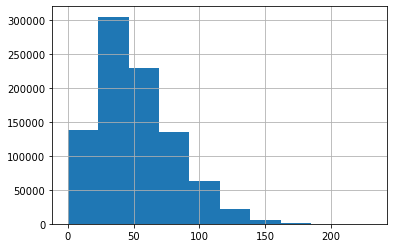

In [59]:
df['sales'].hist()

In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor , RandomForestRegressor , BaggingRegressor
from sklearn.linear_model import TweedieRegressor
# reg = GradientBoostingRegressor().fit(dimX, df['sales'])
reg = TweedieRegressor(power=1, alpha=0.1, link='auto',max_iter=500000 , tol=1e-10 ,verbose=1).fit(xpca, df['sales'])
reg.score(xpca , df['sales'])

0.7079282110318349

In [34]:
X.shape

(900000, 6)

In [13]:
dimX = np.concatenate((df[[ 'ms' , 'mi' , 'msi']].values , dimX) , axis=1)
dimX.shape

(900000, 19)

In [106]:
dimX = np.concatenate((dimX , X) , axis=1)
dimX.shape

(900000, 12)

In [15]:
from sklearn.ensemble import GradientBoostingRegressor 
reg = GradientBoostingRegressor().fit(dimX, df['sales'])
reg.score(dimX , df['sales'])

0.6961831938679226

In [16]:
reg.score(dimX , df['sales'])

0.6961831938679226

## timeseries

In [115]:
df.head()

,id,date,seller,item,sales,datechanged,md,ms,mi,msi
0,0,2015-05-01,1,1,21,20150501,27.392,47.363500,51.451722,46.632222
1,1,2015-05-01,2,1,45,20150501,27.392,67.169411,51.451722,66.156667
2,2,2015-05-01,3,1,28,20150501,27.392,59.649944,51.451722,58.806667
3,3,2015-05-01,4,1,34,20150501,27.392,55.009467,51.451722,53.874444
4,4,2015-05-01,5,1,21,20150501,27.392,39.854267,51.451722,39.338889


## test

In [17]:
dft = pd.read_csv('data/sales/test.csv')
dft.head()

,id,date,seller,item
0,0,2020-04-04,1,1
1,1,2020-04-04,2,1
2,2,2020-04-04,3,1
3,3,2020-04-04,4,1
4,4,2020-04-04,5,1


In [117]:
min(dft['date']) , max(dft['date'])

(Timestamp('2020-04-04 00:00:00'), Timestamp('2020-04-29 00:00:00'))

In [18]:
dft['date'] = pd.to_datetime(dft['date'])

In [18]:
dft['datechanged'] = dft['date'].apply(lambda x : to_integer(x))

In [21]:
dft['md'] = dft['date'].apply(lambda x : get(md,x))
dft['ms'] = dft['seller'].apply(lambda x : get(ms,x))
dft['mi'] = dft['item'].apply(lambda x : get(mi,x))
dft['msi'] = dft.apply(lambda x : get(msi , (x['seller'] , x['item'])) , axis=1)
dft.head()

,id,date,seller,item,md,ms,mi,msi
0,0,2020-04-04,1,1,0,47.363500,51.451722,46.632222
1,1,2020-04-04,2,1,0,67.169411,51.451722,66.156667
2,2,2020-04-04,3,1,0,59.649944,51.451722,58.806667
3,3,2020-04-04,4,1,0,55.009467,51.451722,53.874444
4,4,2020-04-04,5,1,0,39.854267,51.451722,39.338889


In [74]:
Xt=enc.transform(dft[['seller' , 'item' ]].values )

In [75]:
Xt.shape

(13000, 60)

In [24]:
dimXt = svd.transform(Xt)

In [77]:
dimXt = np.concatenate((dft[[ 'ms' , 'mi' , 'msi']].values , Xt.todense()) , axis=1)

In [108]:
Xt = dft[[ 'ms' , 'mi' , 'msi']].values

In [78]:
dimXt=pca.transform(dimXt)
dimXt.shape

(13000, 12)

In [79]:

pred = reg.predict(dimXt)

In [109]:
dimXt = np.concatenate((dimXt , Xt) , axis=1)
dimXt.shape

(13000, 12)

In [128]:
pred = model.predict(Xt.todense())

In [129]:
dft['sales'] = pred
dft.head()

,id,date,seller,item,md,ms,mi,msi,sales
0,0,2020-04-04,1,1,0,47.363500,51.451722,46.632222,48.768757
1,1,2020-04-04,2,1,0,67.169411,51.451722,66.156667,63.889381
2,2,2020-04-04,3,1,0,59.649944,51.451722,58.806667,59.686630
3,3,2020-04-04,4,1,0,55.009467,51.451722,53.874444,56.300602
4,4,2020-04-04,5,1,0,39.854267,51.451722,39.338889,41.373817


In [130]:
dft.describe()

,id,seller,item,md,ms,mi,msi,sales
count,13000.000000,13000.000000,13000.000000,13000.0,13000.000000,13000.000000,13000.000000,13000.000000
mean,6499.500000,5.500000,25.500000,0.0,52.357147,52.357147,52.357147,54.705471
std,3752.921085,2.872392,14.431425,0.0,10.311934,21.357609,24.087267,19.287931
min,0.000000,1.000000,1.000000,0.0,36.439289,18.388667,12.755556,17.703377
25%,3249.750000,3.000000,13.000000,0.0,39.854267,29.459722,31.033472,39.617708
50%,6499.500000,5.500000,25.500000,0.0,55.085478,51.475222,50.141944,55.479589
75%,9749.250000,8.000000,38.000000,0.0,59.649944,69.778389,69.495972,65.368198
max,12999.000000,10.000000,50.000000,0.0,67.169411,88.212778,112.883889,108.430489


In [137]:
df.describe()

,id,seller,item,sales,datechanged,md,ms,mi,msi
count,900000.000000,900000.000000,900000.000000,900000.000000,9.000000e+05,900000.000000,900000.000000,900000.000000,900000.000000
mean,449999.500000,5.500000,25.500000,52.357147,2.017357e+07,52.357147,52.357147,52.357147,52.357147
std,259807.765473,2.872283,14.430878,28.867310,1.457467e+04,12.878385,10.311543,21.356799,24.086354
min,0.000000,1.000000,1.000000,0.000000,2.015050e+07,23.418000,36.439289,18.388667,12.755556
25%,224999.750000,3.000000,13.000000,30.000000,2.016072e+07,42.422500,39.854267,29.459722,31.033472
50%,449999.500000,5.500000,25.500000,47.000000,2.017102e+07,51.812000,55.085478,51.475222,50.141944
75%,674999.250000,8.000000,38.000000,70.000000,2.019011e+07,61.662000,59.649944,69.778389,69.495972
max,899999.000000,10.000000,50.000000,231.000000,2.020040e+07,89.872000,67.169411,88.212778,112.883889


In [131]:
dft[['id' , 'sales']].to_csv('data/sales/ans3.csv',index=False)

In [ ]:
check 

## NN?

In [113]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import SGD

In [124]:
input_dim = X.shape[1]
input_dim

60

In [125]:
def build_model():
    model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
    ])

#     optimizer = tf.keras.optimizers.RMSprop(0.001)
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mse',
                optimizer=sgd,
                metrics=['mae', 'mse'])
    return model


In [126]:
model = build_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               7808      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 16,129
Trainable params: 16,129
Non-trainable params: 0
_________________________________________________________________


In [107]:
np.array(X.todense())

matrix([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]])

In [132]:
EPOCHS = 10

history = model.fit(
  np.array(X.todense()), df['sales'],
  epochs=EPOCHS, validation_split = 0.2, verbose=1)

Epoch 1/10
22500/22500 [==============================] - 12s 555us/step - loss: 273.8156 - mae: 12.5449 - mse: 273.8156 - val_loss: 709.1568 - val_mae: 22.2447 - val_mse: 709.1568
Epoch 2/10
22500/22500 [==============================] - 13s 592us/step - loss: 273.3539 - mae: 12.5306 - mse: 273.3539 - val_loss: 697.6451 - val_mae: 21.9191 - val_mse: 697.6451
Epoch 3/10
22500/22500 [==============================] - 13s 585us/step - loss: 273.4365 - mae: 12.5388 - mse: 273.4365 - val_loss: 683.2867 - val_mae: 21.5591 - val_mse: 683.2867
Epoch 4/10
22500/22500 [==============================] - 13s 586us/step - loss: 273.3191 - mae: 12.5359 - mse: 273.3191 - val_loss: 700.4857 - val_mae: 21.9922 - val_mse: 700.4857
Epoch 5/10
22500/22500 [==============================] - 13s 583us/step - loss: 273.5234 - mae: 12.5393 - mse: 273.5234 - val_loss: 728.2436 - val_mae: 22.7036 - val_mse: 728.2436
Epoch 6/10
22500/22500 [==============================] - 13s 587us/step - loss: 273.3626 - mae

In [123]:
model.save('model.h5')